# From Hugging Face Dataset to PyTorch DataLoaders and MX Arrays

This guide walks you through loading a dataset with Hugging Face, batching and collating the data using PyTorch’s DataLoader, and converting the tensors to MX arrays for neural network input, here are the steps:

0. Why Not `mlx.data` ?
1. Load Dataset from Hugging Face
2. Define Your Transforms
3. Leverage PyTorch DataLoaders with a Custom Collate Function
4. Verify the Setup
5. Full Snippet 

### Install Deps

[Install PyTorch if needed](https://pytorch.org/get-started/locally/)

Install Hugging Face Datasets Library

In [ ]:
%pip install datasets

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import mlx
import mlx.core as mx

### 0. Why Not Use `mlx.data`?

While using PyTorch utilities does introduce a bit of dependency overload, we don't have to reinvent the wheel and we can stick to the usual industry workflow.

### 1. Load Dataset from Hugging Face

Let's use HuggingFace's `datasets` library to load the files

In [16]:
from datasets import load_dataset

ds_name = "ylecun/mnist"
ds = load_dataset(ds_name)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We’ll use only the training set for now, splitting it into two parts:
- Training Set: 80% for training our model.
- Validation Set: 20% for checking the model’s accuracy at each epoch.

We’ll keep the test set aside for the final evaluation to see how our model performs on completely unseen data.

In [17]:
ds = ds['train'].train_test_split(test_size=0.2)

# just some renaming to stay consistent with what I just said
ds['val'] = ds['test']
del ds['test']
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 48000
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
})

Let's take a look at the first sample

In [18]:
# Display a sample image and label from the training set
sample = ds['train'][0]
sample['image']

In [19]:
print('the above image is supposed to be a', sample['label'])

the above image is supposed to be a 8


### 2. Define Your Transforms

At this point we got a PILImage which is not useful for our model, so we need to define a `transform` to go from PIL To Tensors

In [20]:
from torchvision import transforms

# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    lambda x: x.view(-1)  # Flatten to 1D array of 784 pixels
])

# Apply transformation to the dataset
def transform_dataset(batch):
    batch['image'] = [transform(image) for image in batch['image']]
    return batch

# Apply the transformation to the dataset
transformed = ds.with_transform(transform_dataset)

# Example of accessing transformed data
type(transformed['train'][0]['image']), transformed['train'][0]['image'].shape

(torch.Tensor, torch.Size([784]))

> Note that this part `lambda x: x.view(-1)` may vary depending on the requirements of your neural network. A flat tensor is suitable for a multi-layer perceptron, but for a convolutional network, you might need a 3-dimensional tensor.

Let's verify that we can still display the image

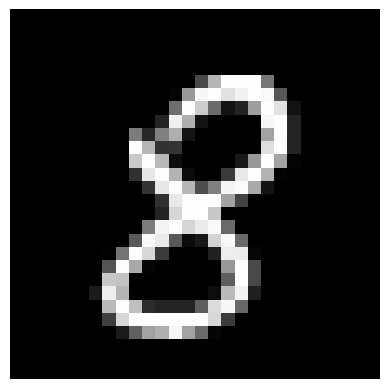

In [21]:
# helper to display an image
import matplotlib.pyplot as plt

def np_show_img(array, title=''):
    if array.ndim == 1:  # If rank 1, reshape to 2D
        array = array.reshape(28, 28)
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()

np_show_img(transformed['train'][0]['image'])

### 3. Leverage PyTorch DataLoaders with a Custom Collate Function

So, we successfully applied the transform, but in practice we don't apply transforms on the dataset all at once. We do that in batches, load the stuff in parallel, cache the results, etc.

Let's not bother rewriting all this stuff!

Instead we can leverage `DataLoader` and `Dataset` classes from the PyTorch utility library and apply a custom collate function to collect our mlx arrays.

In [22]:
batch_size=32

In [23]:
from torch.utils.data import DataLoader, Dataset
import mlx.core as mx

# Custom Dataset class to match what the data structure we got from hugging face
class MNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# 👇 The important part
def mlx_collate_fn(batch):
    images, labels = zip(*batch)
    images = mx.array([mx.array(image.numpy()) for image in images])
    labels = mx.array(labels)
    return images, labels

# Create DataLoaders with the custom collate function
def create_dataloader(dataset, transform=None, batch_size=32, shuffle=False):
    return DataLoader(MNISTDataset(dataset, transform=transform), # 👈 here we pass the transform we defined earlier
                      batch_size=batch_size,
                      shuffle=shuffle,
                      collate_fn=mlx_collate_fn)


train_loader = create_dataloader(ds['train'], transform=transform, batch_size=batch_size, shuffle=True)
val_loader = create_dataloader(ds['val'], batch_size=batch_size, shuffle=False)

### 4. Verify the Setup

inputs: <class 'mlx.core.array'> (32, 784)
labels: <class 'mlx.core.array'> (32,)
The image should display a  0


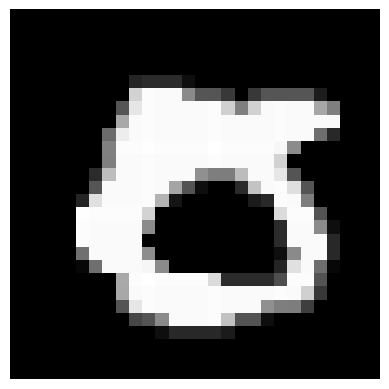

In [24]:
for inputs, labels in train_loader:
    print('inputs:', type(inputs), inputs.shape)
    print('labels:', type(labels), labels.shape)
   
    print('The image should display a ', labels[0].item())
    np_show_img(inputs[0])
    break

### 5. Full Snippet

In [25]:
batch_size=32

inputs: <class 'mlx.core.array'> (32, 784)
labels: <class 'mlx.core.array'> (32,)
The image should display a  1


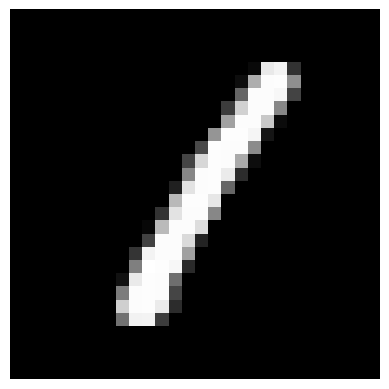

In [26]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import mlx
import mlx.core as mx

# just a helper to show img
def np_show_img(array, title=''):
    if array.ndim == 1:  # If rank 1, reshape to 2D
        array = array.reshape(28, 28)
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()


# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    lambda x: x.view(-1)  # Flatten to 1D array of 784 pixels
])

# Apply transformation to the dataset
def transform_dataset(batch):
    batch['image'] = [transform(image) for image in batch['image']]
    return batch

class MNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# 👇 The important part
def mlx_collate_fn(batch):
    images, labels = zip(*batch)
    images = mx.array([mx.array(image.numpy()) for image in images])
    labels = mx.array(labels)
    return images, labels

# Create DataLoaders with the custom collate function
def create_dataloader(dataset, transform=None, batch_size=32, shuffle=False):
    return DataLoader(MNISTDataset(dataset, transform=transform), # 👈 here we pass the transform we defined earlier
                      batch_size=batch_size,
                      shuffle=shuffle,
                      collate_fn=mlx_collate_fn)



ds_name = "ylecun/mnist"
ds = load_dataset(ds_name)
ds = ds['train'].train_test_split(test_size=0.2)
ds['val'] = ds['test']
del ds['test']

train_loader = create_dataloader(ds['train'], transform=transform, batch_size=batch_size, shuffle=True)
val_loader = create_dataloader(ds['val'], transform=transform, batch_size=batch_size, shuffle=False)

for inputs, labels in train_loader:
    print('inputs:', type(inputs), inputs.shape)
    print('labels:', type(labels), labels.shape)
   
    print('The image should display a ', labels[0].item())
    np_show_img(inputs[0])
    break

Done! You are now ready to fed these mxarrays to your mx neural net